## <div align=center>Diversity vs. Human Development Analysis Project</div>
### <div align=center>Connor Collins, Andrew Nguyen</div>
### <div align=center>OMIS 114</div>
### <div align=center>1 December 2020</div>

### <div align=center>In western civilization, it is often said by various activists, pundits and politicians that "diversity is our strength," implying that a higher level of diversity in a given nation is indicative or a contributing factor to economic prosperity and/or a higher standard of living.  This study will attempt to examine the truth of such a claim by comparing UN Human Development Index (HDI) data of a given nation with their level of ethnic diversity (measured in Ethnic Fractionalization Index or EFI) to see if there is any correlation.  Afterwards, we will compare EFI with the each individual subcomponent of HDI (such as Economy, Education, etc) to see if there are any correlations in specific aspects of HDI. Additionally we will compare EFI with a country's level of happiness (UN Happiness Index) as we believe collective happiness ought to be a factor in a country's quality of life.  </div>

In [190]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib.ticker as ticker
import matplotlib as mpl
import numpy as np
from functools import reduce
from sklearn import linear_model
pd.set_option('display.max_rows', None, 'display.max_columns', None)

## Loading the Data

### Summary of data used in this project (in order of invocation):

###### <u>United Nations Data:</u>
<ul>
    <li>      <b>Human Development Index (HDI)</b>:  measures a country's level of human development as a composite of the variables below (Higher = Better)<br>
        <ul><li>       <b>Schooling Years</b>:  measures the average length of schooling for a given country (Higher = Better)<br>
            <li>       <b>Exports + Imports</b>:  measures openess to trade by summing a country's Exports and Imports as a percentage of their GDP ((Higher = Better)<br>
            <li>       <b>Gender Development Index</b>: measures the HDI-sex-gap using a ratio between Males-only HDI and Females-only HDI (Lower = Better)<br>
 <li>      <b>Gross National Income (per capita)</b>: aka Purchasing Power Parity (PPP), GNI measures the spending power of an average person in a given country in raw dollar terms (Higher = Better)<br>
 <li>     <b>Inequality-adjusted HDI</b>: measures inequality by producing an HDI score adjusted for inequality (Higher = Better)<br>
 <li>       <b>Internet Users</b>: measures mobility and communication through the percentage of people who have internet access (Higher = Better)<br>
 <li>       <b>Life Expectancy</b>:  measures human security through the average life expectancy of a country (Higher = Better)<br>
 <li>      <b>Population</b>:  measures demography via the total population of a country in millions (Higher = More Crowded)<br>
 <li>       <b>Skilled Labor</b>: measures socio-economic stability by seeing how much of the labor force is skilled (Higher = Better)<br>
 <li>      <b>Employment</b>: measures the percentage of the population that is employed (Higher = Better, mostly)<br>
 <li>       <b>Homicide Rate</b>: measures human security by capturing the number of homicides per 100k people (Lower = Better)<br>
 <li>      <b>World Happiness Report</b>: measures a country's level of self-reported happiness (Higher = Better)<br>
     </ul>
</ul>

##### <u>Harvard Data:</u>
<ul>
    <li> <b>Historical Index of Ethnic Fractionalization (HIEF)</b>: measures a country's level of diversity (Higher score = More diverse) <br>
<ul>

In [191]:
hdi=pd.read_csv('Human Development Index (HDI).csv')
hief_data=pd.read_csv('HIEF_data.csv')

schooling_years=pd.read_csv('Expected years of schooling (years).csv')
exports_imports=pd.read_csv('Exports and imports (% of GDP).csv')
gender_development=pd.read_csv('Gender Development Index (GDI).csv')
gni_per_capita=pd.read_csv('Gross national income (GNI) per capita (2011 PPP$).csv')
homicide_rate=pd.read_csv('Homicide rate (per 100,000 people).csv')
inequality=pd.read_csv('Inequality-adjusted HDI (IHDI).csv')
internet_users=pd.read_csv('Internet users, total (% of population).csv')
life_exp=pd.read_csv('Life expectancy at birth.csv')
population=pd.read_csv('Population, total (millions).csv')
skilled_labor=pd.read_csv('Skilled labour force (% of labour force).csv')
employment=pd.read_csv('Employment to population ratio (% ages 15 and older).csv')

whr=pd.read_excel('WHR20_DataForFigure2.1.xls')

data_frames=[schooling_years, exports_imports, gender_development, gni_per_capita, homicide_rate, inequality, 
            internet_users, life_exp, population, skilled_labor, employment]

## Cleaning

In [192]:
## The csv files generate dataframes with no headers, this method fixes that problem.
def fix_csv(csv):
    csv.reset_index(inplace=True)
    new_headers=csv.iloc[0]
    csv.columns=new_headers
    csv.drop(index=0, inplace=True)
    csv=csv.loc[:, csv.columns.notnull()]
    csv=csv.loc[csv['2013']!='..']

In [193]:
## We apply the function to the dataframes in need 
fix_csv(schooling_years)
fix_csv(exports_imports)
fix_csv(gender_development)
fix_csv(gni_per_capita)
fix_csv(homicide_rate)
fix_csv(inequality)
fix_csv(internet_users)
fix_csv(life_exp)
fix_csv(population)
fix_csv(skilled_labor)
fix_csv(employment)
fix_csv(hdi)

We are only concerned with the most current level of diversity, so we merely extract the 2013 numbers to save on cleaning.

In [194]:
hief_data = hief_data.loc[hief_data['Year']==2013]

Problem: Dataframes pertaining to HDI and HDI subcomponents have lots of useless data under Zimbabwe

Assumptions:
<ul>
<li>All UN HDI dataframes already arranged their countries in alphabetical order
<li>Zimbabwe should, therefore, always be the last data entry in any HDI-related dataframe
</ul>

Solution: Make a function that captures the index of a given DataFrame's 'Zimbabwe' entry and drop every entry after it

In [195]:
## .index on a DataFrame returns an int64, which can't be used in index range operations.
## We must thus convert the int64 into an int.
## Using .tolist()[0] effectively achieves this.
## We now have a new function that cleans up HDI data after Zimbabwe.

def zim_index_drop(df):
    zim_index = df[df.Country == 'Zimbabwe'].index.tolist()[0]
    df = df.drop(df.index[(zim_index + 1):], inplace=True)
    
def zim_index_find(df):
    zim_index = df[df.Country == 'Zimbabwe'].index.tolist()[0]
    return zim_index

In [196]:
## Here the function is applied to the dataframes.

zim_index_drop(hdi)
zim_index_drop(schooling_years)
zim_index_drop(exports_imports)
zim_index_drop(gender_development)
zim_index_drop(gni_per_capita)
zim_index_drop(homicide_rate)
zim_index_drop(inequality)
zim_index_drop(internet_users)
zim_index_drop(life_exp)
zim_index_drop(population)
zim_index_drop(skilled_labor)
zim_index_drop(employment)

In [197]:
## Here we clean the columns of every individual dataframe.

hdi = hdi.loc[:, hdi.columns.notnull()].loc[hdi['2013']!='..'].loc[hdi['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
schooling_years = schooling_years.loc[:, schooling_years.columns.notnull()].loc[schooling_years['2013']!='..'].loc[schooling_years['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
exports_imports = exports_imports.loc[:, exports_imports.columns.notnull()].loc[exports_imports['2013']!='..'].loc[exports_imports['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
gender_development = gender_development.loc[:, gender_development.columns.notnull()].loc[gender_development['2013']!='..'].loc[gender_development['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
gni_per_capita = gni_per_capita.loc[:, gni_per_capita.columns.notnull()].loc[gni_per_capita['2013']!='..'].loc[gni_per_capita['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
homicide_rate = homicide_rate.loc[:, homicide_rate.columns.notnull()].loc[homicide_rate['2013']!='..'].loc[homicide_rate['2017']!='..'][['HDI Rank (2018)', 'Country', '2013', '2017']]
inequality = inequality.loc[:, inequality.columns.notnull()].loc[inequality['2013']!='..'].loc[inequality['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
internet_users = internet_users.loc[:, internet_users.columns.notnull()].loc[internet_users['2013']!='..'].loc[internet_users['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
life_exp = life_exp.loc[:, life_exp.columns.notnull()].loc[life_exp['2013']!='..'].loc[life_exp['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
population = population.loc[:, population.columns.notnull()].loc[population['2013']!='..'].loc[population['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
skilled_labor = skilled_labor.loc[:, skilled_labor.columns.notnull()].loc[skilled_labor['2013']!='..'].loc[skilled_labor['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]
employment = employment.loc[:, employment.columns.notnull()].loc[employment['2013']!='..'].loc[employment['2018']!='..'][['HDI Rank (2018)', 'Country', '2013', '2018']]

Naming Convention for UN Data:

 hdi:      Human Development Index score <br>
 sy:       Schooling Years <br>
 ei:       Exports + Imports (percentage of GDP) <br>
 gd:       Gender Development Index<br>
 gni:      Gross National Income (per capita)<br>
 ineq:     Inequality-adjusted HDI<br>
 iu:       Internet Users (as % of pop)<br>
 le:       Life Expectancy<br>
 pop:      Population<br>
 sl:       Skilled Labor (as % of labor force)<br>
 emp:      Employment (ratio to pop)<br>
 hr:       Homicide Rate<br>
 

In [198]:
## Here we begin to rename the dataframe columns in accordance to the naming convention above.
## This will allow us to merge the data without a loss in readibility.
hdi.rename(columns={'2013':'hdi_2013', '2018':'hdi_2018'}, inplace=True)
schooling_years.rename(columns={'2013':'sy_2013', '2018':'sy_2018'}, inplace=True)
exports_imports.rename(columns={'2013':'ei_2013', '2018':'ei_2018'}, inplace=True)     
gender_development.rename(columns={'2013':'gd_2013', '2018':'gd_2018'}, inplace=True)
gni_per_capita.rename(columns={'2013':'gni_2013', '2018':'gni_2018'}, inplace=True)
inequality.rename(columns={'2013':'ineq_2013', '2018':'ineq_2018'}, inplace=True)
internet_users.rename(columns={'2013':'iu_2013', '2018':'iu_2018'}, inplace=True)
life_exp.rename(columns={'2013':'le_2013', '2018':'le_2018'}, inplace=True)
population.rename(columns={'2013':'pop_2013', '2018':'pop_2018'}, inplace=True)
skilled_labor.rename(columns={'2013':'sl_2013', '2018':'sl_2018'}, inplace=True)
employment.rename(columns={'2013':'emp_2013', '2018':'emp_2018'}, inplace=True)

## The latest Homicide Rate data is 2017, so this will stand in for 2018. 
homicide_rate.rename(columns={'2013':'hr_2013', '2017':'hr_2018'}, inplace=True)

In [199]:
## This removes the "year" column in the dataframe because it is useless.
hief_data = hief_data[['Country', 'EFindex']]

In [200]:
## We then rename the columns in the hief_data.
hief_data = hief_data.rename(columns={"EFindex":"EFIndex_2013"})

In [201]:
## This sorts the countries by alphabetical order, to better align the datasets.
hief_data = hief_data.sort_values('Country')

In [202]:
## This resets the index numbering of the dataset by creating an additional column to the left.
hief_data = hief_data.reset_index()

In [203]:
## This deletes the old index column
hief_data = hief_data.drop(columns=['index'])

In [204]:
## WHR data requires minimal cleaning, we extract the only pertinent columns from the original data.
whr=whr[['Country name', 'Ladder score']].rename(columns={'Country name': 'Country'})

In [205]:
## Now we begin the process of creating the unified dataframe.
hdi_w_hief=hdi.merge(hief_data, how='outer')

In [206]:
## From here we encounter a problem, all appearing AFTER the zimbabwe index.
hdi_w_hief

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
0,170,Afghanistan,0.485,0.496,0.763
1,69,Albania,0.781,0.791,0.139
2,82,Algeria,0.746,0.759,0.372
3,36,Andorra,0.846,0.857,NaN
4,149,Angola,0.547,0.574,0.779
5,74,Antigua and Barbuda,0.767,0.776,NaN
6,48,Argentina,0.824,0.830,0.158
7,81,Armenia,0.743,0.760,0.045
8,6,Australia,0.926,0.938,0.276
9,20,Austria,0.896,0.914,0.248


In [207]:
## There should only be NaN values in the EFIndex column.
## This problem will be addressed later in the notebook.
hdi_w_hief.isna().sum()

HDI Rank (2018)    25
Country             0
hdi_2013           25
hdi_2018           25
EFIndex_2013       57
dtype: int64

#### Here we encountered a problem pertaining to naming discrepencies between the EFI data and the UN data.  Here we take an aside from the current merging process to address it.

In [208]:
## Here the zim_index functions come in handy once again, this time to capture the naming-error countries
lostnats = hdi_w_hief.iloc[zim_index_find(hdi_w_hief) + 1:]

In [209]:
## Out of the 57 countries that are NaN-ed, 25 of them should NOT be
len(lostnats)

25

In [210]:
## This is all the countries we lost due to naming discrepencies between the two datasets.
lostnats

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
188,NaN,Bolivia,NaN,NaN,0.572
189,NaN,Bosnia-Herzegovina,NaN,NaN,0.637
190,NaN,Cape Verde,NaN,NaN,0.442
191,NaN,Cote d'Ivoire,NaN,NaN,0.731
192,NaN,Czech Republic,NaN,NaN,0.262
193,NaN,Democratic People's Republic of Korea,NaN,NaN,0.020
194,NaN,Democratic Republic of Congo,NaN,NaN,0.700
195,NaN,Democratic Republic of Vietnam,NaN,NaN,0.263
196,NaN,East Timor,NaN,NaN,0.802
197,NaN,German Federal Republic,NaN,NaN,0.189


In [211]:
## Here we generate the lists of country names to be renamed
EFI_names = lostnats.Country.tolist()
UN_names = ["Bolivia (Plurinational State of)", "Bosnia and Herzegovina", 
            "Cabo Verde", "Côte d'Ivoire", "Czechia", "EXCLUDE NORTH KOREA", 
            "Congo (Democratic Republic of the)", "Viet Nam", "Timor-Leste", 
            "Germany", "Iran (Islamic Republic of)", "Kyrgyzstan", "Lao People's Democratic Republic", 
            "North Macedonia", "Moldova (Republic of)", "Korea (Republic of)", "Russian Federation", 
            "EXCLUDE SOMALIA", "Eswatini (Kingdom of)", "Syrian Arab Republic", 
            "No Taiwan...suspicious *cough*China*cough*", "Tanzania (United Republic of)", 
            "United States", "Venezuela (Bolivarian Republic of)", "Yemen"]

In [212]:
## Here we verify that the number of EFI countries to be renamed total 25
len(EFI_names)

25

In [213]:
## Here we verify that the number of UN countries total 25
len(UN_names)

25

In [214]:
## Here the EFI countries are being renamed to conform with the UN naming conventions.
## This will be the hief_data being used going forward
hief_data_renamed = hief_data.replace(EFI_names, UN_names)

In [215]:
## Now we conduct a merge with the hief_data fixed naming-wise.
hdi_w_hief = hdi.merge(hief_data_renamed, how='left')

In [216]:
## Checking to verify a successful first merge.
## The merge is successful.
hdi_w_hief

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
0,170,Afghanistan,0.485,0.496,0.763
1,69,Albania,0.781,0.791,0.139
2,82,Algeria,0.746,0.759,0.372
3,36,Andorra,0.846,0.857,NaN
4,149,Angola,0.547,0.574,0.779
5,74,Antigua and Barbuda,0.767,0.776,NaN
6,48,Argentina,0.824,0.830,0.158
7,81,Armenia,0.743,0.760,0.045
8,6,Australia,0.926,0.938,0.276
9,20,Austria,0.896,0.914,0.248


In [217]:
## Further cleaning of this initial merge.
hdi_w_hief.reset_index()

,index,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013
0,0,170,Afghanistan,0.485,0.496,0.763
1,1,69,Albania,0.781,0.791,0.139
2,2,82,Algeria,0.746,0.759,0.372
3,3,36,Andorra,0.846,0.857,NaN
4,4,149,Angola,0.547,0.574,0.779
5,5,74,Antigua and Barbuda,0.767,0.776,NaN
6,6,48,Argentina,0.824,0.830,0.158
7,7,81,Armenia,0.743,0.760,0.045
8,8,6,Australia,0.926,0.938,0.276
9,9,20,Austria,0.896,0.914,0.248


In [218]:
## Now we merge the hdi_w_hief with the rest of the HDI data.
df_minus_whr=hdi_w_hief.merge(schooling_years, how='left').merge(gender_development, how='left').merge(gni_per_capita, 
    how='left').merge(homicide_rate, how='left').merge(inequality, how='left').merge(internet_users, how='left'
    ).merge(life_exp, how='left').merge(population, how='left').merge(skilled_labor, how='left'
    ).merge(employment, how='left').merge(exports_imports, how='left')

## Since the WHR follows a different naming convention than all the HDI data, we must undergo the same fixing process.
## To collect badly named countries, we use the outer merge like before.
whr_to_fix=df_minus_whr.merge(whr, how='outer')

In [219]:
## Here we once again put zim_index to use.
lostnats2 = whr_to_fix.iloc[zim_index_find(whr_to_fix) + 1:]

## We now create the list of bad names from WHR.
WHR_names=lostnats2.Country.tolist()
WHR_names

['Czech Republic',
 'Taiwan Province of China',
 'Kosovo',
 'South Korea',
 'Bolivia',
 'Moldova',
 'Russia',
 'North Cyprus',
 'Hong Kong S.A.R. of China',
 'Vietnam',
 'Ivory Coast',
 'Congo (Brazzaville)',
 'Macedonia',
 'Venezuela',
 'Laos',
 'Iran',
 'Palestinian Territories',
 'Congo (Kinshasa)',
 'Swaziland',
 'Tanzania']

In [220]:
## Here we replace the WHR country names to conform to HDI naming conventions.
whr.replace({'Czech Republic':'Czechia', 'South Korea':'Korea (Republic of)', 'Bolivia':'Bolivia (Plurinational State of)', 
            'Moldova':'Moldova (Republic of)', 'Russia':'Russian Federation', 'Vietnam':'Viet Nam', 'Ivory Coast':
            'Côte d\'Ivoire', 'Macedonia':'North Macedonia', 'Venezuela':'Venezuela (Bolivarian Republic of)', 
            'Laos':'Lao People\'s Democratic Republic', 'Iran':'Iran (Islamic Republic of)', 'Congo (Kinshasha)':
            'Congo', 'Congo (Brazzaville)':'Congo (Democratic Republic of the)', 'Tanzania':'Tanzania (United Republic of)'}, inplace=True)

In [221]:
## At last we generate the final unified DataFrame.
final_df=df_minus_whr.merge(whr, how='left')
final_df.rename(columns={'Ladder score':'Happiness score'}, inplace=True)

##### After this point all dataframes are officially clean and the unified dataframe going forward has been established.

# Data Analysis

In [222]:
## This converts the data entries into floats for the sake of plotting.
cols_to_make_ints=final_df.columns.drop('Country')
final_df[cols_to_make_ints]=final_df[cols_to_make_ints].astype(float)

## We display the correalations here before visualizing through graphs below.
final_df.corr()

,HDI Rank (2018),hdi_2013,hdi_2018,EFIndex_2013,sy_2013,sy_2018,gd_2013,gd_2018,gni_2013,gni_2018,hr_2013,hr_2018,ineq_2013,ineq_2018,iu_2013,iu_2018,le_2013,le_2018,pop_2013,pop_2018,sl_2013,sl_2018,emp_2013,emp_2018,ei_2013,ei_2018,Happiness score
HDI Rank (2018),1.000000,-0.987694,-0.989913,0.440290,-0.901057,-0.900856,-0.596199,-0.568903,-0.769137,-0.799287,0.402897,0.371489,-0.980324,-0.983704,-0.873993,-0.835587,-0.887675,-0.897149,0.015200,0.022143,-0.637296,-0.587363,0.181737,0.124640,-0.360517,-0.374882,-0.803718
hdi_2013,-0.987694,1.000000,0.996721,-0.465107,0.903860,0.895588,0.627414,0.594218,0.741226,0.765598,-0.358532,-0.315049,0.980738,0.983234,0.868476,0.846282,0.907182,0.910987,-0.012133,-0.019220,0.633986,0.580846,-0.232044,-0.182608,0.339940,0.351384,0.788822
hdi_2018,-0.989913,0.996721,1.000000,-0.453018,0.904347,0.903965,0.630031,0.604070,0.734262,0.762982,-0.370858,-0.332647,0.977896,0.984590,0.866279,0.844309,0.900597,0.908396,0.001463,-0.005436,0.638070,0.587356,-0.220411,-0.168987,0.346707,0.356594,0.793014
EFIndex_2013,0.440290,-0.465107,-0.453018,1.000000,-0.429574,-0.408891,-0.288524,-0.234449,-0.191427,-0.217268,0.102891,0.074296,-0.555829,-0.549842,-0.157943,-0.072199,-0.512635,-0.516812,-0.042707,-0.034188,-0.438985,-0.375020,0.249211,0.219560,-0.129100,-0.148224,-0.233367
sy_2013,-0.901057,0.903860,0.904347,-0.429574,1.000000,0.984652,0.627840,0.604969,0.591591,0.620910,-0.367879,-0.307301,0.911480,0.909497,0.720809,0.683288,0.791292,0.798943,-0.014530,-0.021012,0.406206,0.403669,-0.185341,-0.136827,0.214021,0.230378,0.736886
sy_2018,-0.900856,0.895588,0.903965,-0.408891,0.984652,1.000000,0.599615,0.580896,0.589199,0.621046,-0.393089,-0.332487,0.902181,0.905674,0.719225,0.684513,0.782079,0.791332,0.001528,-0.004640,0.368628,0.366786,-0.171164,-0.124457,0.219156,0.232789,0.746108
gd_2013,-0.596199,0.627414,0.630031,-0.288524,0.627840,0.599615,1.000000,0.981274,0.396126,0.407912,0.079821,0.101094,0.576178,0.580151,0.513251,0.634259,0.491609,0.510785,-0.063261,-0.070737,0.375643,0.484046,0.009952,0.042842,0.237516,0.271633,0.440424
gd_2018,-0.568903,0.594218,0.604070,-0.234449,0.604969,0.580896,0.981274,1.000000,0.373221,0.386621,0.088022,0.098465,0.539046,0.548320,0.497538,0.621427,0.462482,0.483790,-0.059140,-0.066327,0.346739,0.458956,0.046207,0.078666,0.232795,0.262058,0.436218
gni_2013,-0.769137,0.741226,0.734262,-0.191427,0.591591,0.589199,0.396126,0.373221,1.000000,0.992078,-0.366653,-0.350611,0.857730,0.850106,0.697130,0.723639,0.629218,0.637496,-0.044671,-0.048890,0.469673,0.436450,0.063396,0.098198,0.472221,0.460355,0.731108
gni_2018,-0.799287,0.765598,0.762982,-0.217268,0.620910,0.621046,0.407912,0.386621,0.992078,1.000000,-0.386937,-0.374120,0.865695,0.860203,0.735702,0.743847,0.656819,0.667495,-0.033940,-0.038368,0.498680,0.459319,0.050749,0.092362,0.508320,0.499011,0.750428


## Analysis #1:  EFI vs HDI

#### Iteration #1: EFI 2013 vs HDI 2018

In [223]:
## This is the general format for all the analyses.
## The rest of the graphs in this section will not be annotated for this reason.

## We isolate the data into a new dataframe so as to not molest the unified dataframe.
## NaNs are then dropped at this point.
analysis_1=final_df[['hdi_2018', 'EFIndex_2013', 'hdi_2013']].dropna()

## An analysis-specific correlation graph is also generated for you conveinence.
analysis_1.corr()

## Here we create the stat_func that allows us to display our coefficient of determination (aka. R squared).
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


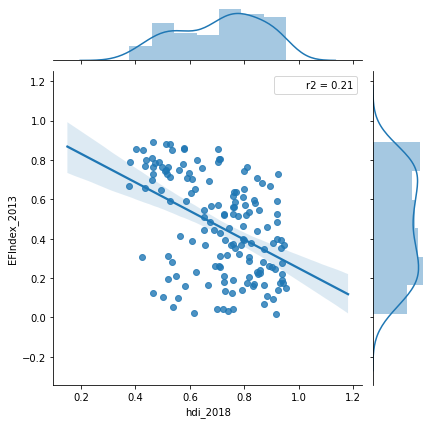

In [224]:
## The graph is generated.
sns.jointplot(data=analysis_1, x='hdi_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs HDI 2013

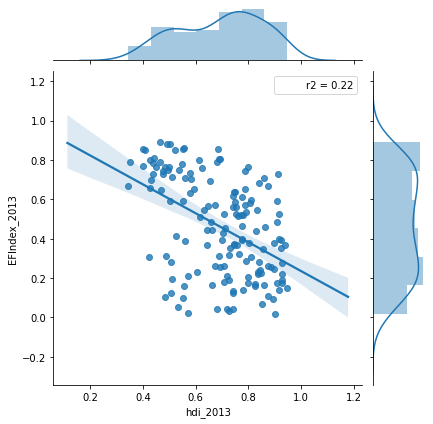

In [225]:
## The second iteration for the sake of contemporary accuracy.
sns.jointplot(data=analysis_1, x='hdi_2013', y='EFIndex_2013', stat_func=r2, kind='reg')

## Analysis #2: EFI vs Years of Schooling (SY)

In [226]:
analysis_2=final_df[['EFIndex_2013', 'sy_2018', 'sy_2013']].dropna()

#### Iteration #1: EFI 2013 vs SY 2018

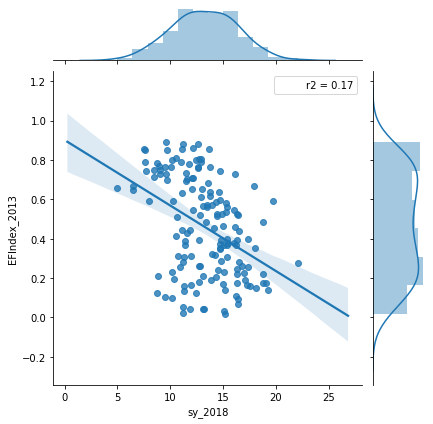

In [227]:
sns.jointplot(data=analysis_2, x='sy_2018', y='EFIndex_2013', stat_func=r2, kind='reg')

#### Iteration #2: EFI 2013 vs SY 2013

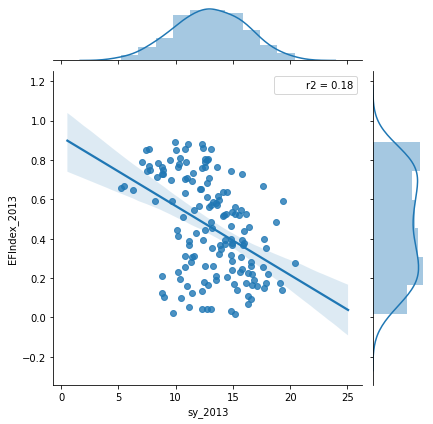

In [228]:
sns.jointplot(data=analysis_2, x='sy_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

## Analysis #3: EFI vs Exports + Imports (EI)

#### Iteration #1:  EFI 2013 vs EI 2018

In [229]:
analysis_3=final_df[['EFIndex_2013', 'ei_2018', 'ei_2013']].dropna()
analysis_3.corr()

,EFIndex_2013,ei_2018,ei_2013
EFIndex_2013,1.000000,-0.148224,-0.129100
ei_2018,-0.148224,1.000000,0.937323
ei_2013,-0.129100,0.937323,1.000000


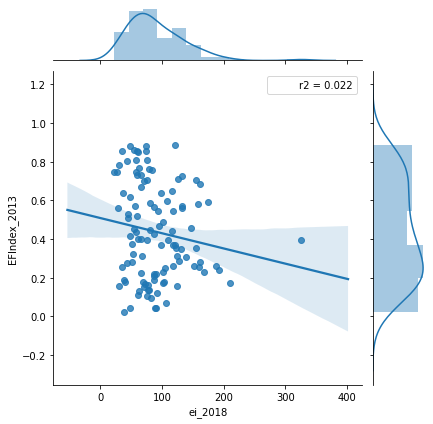

In [230]:
sns.jointplot(data=analysis_3, x='ei_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

Remove outlier to ensure the trend line is still the same

In [231]:
outlier_index=analysis_3.sort_values('ei_2018', ascending=False).head(1).index[0]
analysis_3.drop([outlier_index], inplace=True)

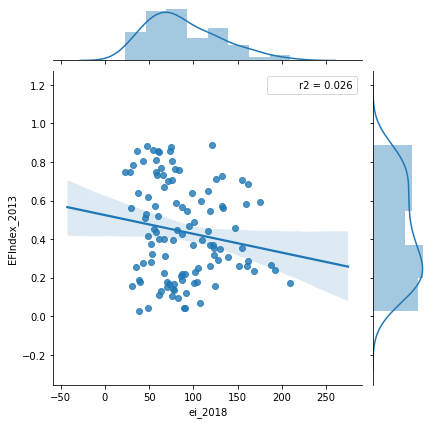

In [232]:
sns.jointplot(data=analysis_3, x='ei_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs EI 2013

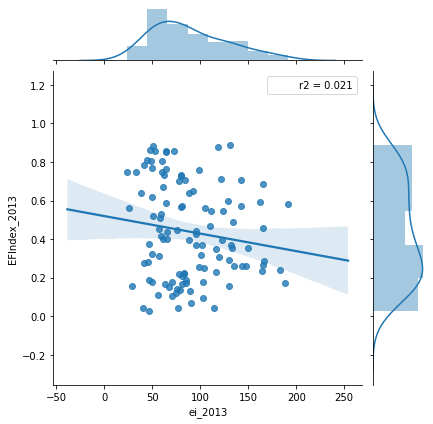

In [233]:
sns.jointplot(data=analysis_3, x='ei_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #4: EFI vs Gender Development (gd)

#### Iteration #1: EFI 2013 vs GD 2018

In [234]:
analysis_4=final_df[['EFIndex_2013', 'gd_2018', 'gd_2013']].dropna()
analysis_4.corr()

,EFIndex_2013,gd_2018,gd_2013
EFIndex_2013,1.000000,-0.234449,-0.288524
gd_2018,-0.234449,1.000000,0.980825
gd_2013,-0.288524,0.980825,1.000000


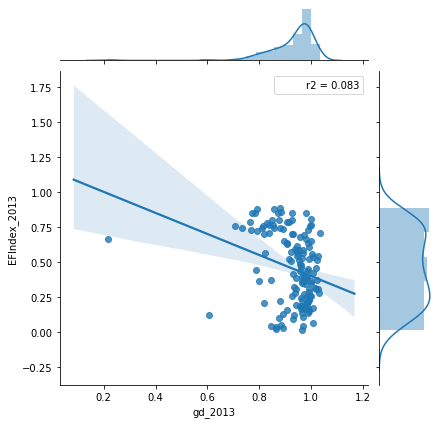

In [235]:
sns.jointplot(data=analysis_4, x='gd_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs GD 2013

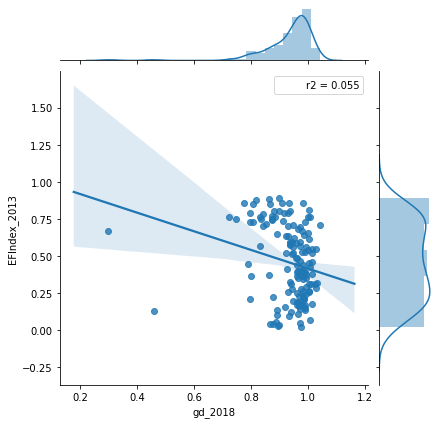

In [236]:
sns.jointplot(data=analysis_4, x='gd_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #5: EFI vs GNI per Capita (GNI)

#### Iteration #1: EFI 2013 vs GNI 2018

In [237]:
analysis_5=final_df[['EFIndex_2013', 'gni_2018', 'gni_2013']].dropna()
analysis_5.corr()

,EFIndex_2013,gni_2018,gni_2013
EFIndex_2013,1.000000,-0.217268,-0.191427
gni_2018,-0.217268,1.000000,0.991283
gni_2013,-0.191427,0.991283,1.000000


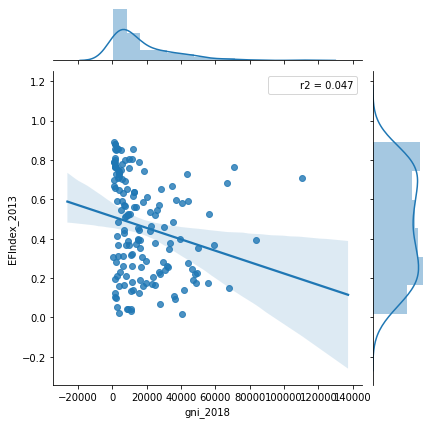

In [238]:
sns.jointplot(data=analysis_5, x='gni_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EF 2013 vs GNI 2013

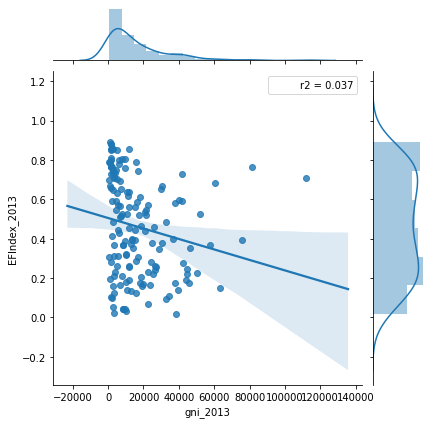

In [239]:
sns.jointplot(data=analysis_5, x='gni_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #6: EFI vs Homicide Rate (HR)

#### Iteration #1: EFI 2013 vs Homicide Rate 2017 (There was no hr data for 2018)

In [240]:
analysis_6=final_df[['EFIndex_2013', 'hr_2018', 'hr_2013']].dropna()
analysis_6.corr()
final_df

,HDI Rank (2018),Country,hdi_2013,hdi_2018,EFIndex_2013,sy_2013,sy_2018,gd_2013,gd_2018,gni_2013,gni_2018,hr_2013,hr_2018,ineq_2013,ineq_2018,iu_2013,iu_2018,le_2013,le_2018,pop_2013,pop_2018,sl_2013,sl_2018,emp_2013,emp_2018,ei_2013,ei_2018,Happiness score
0,170.0,Afghanistan,0.485,0.496,0.763,10.2,10.1,0.707,0.723,1814.0,1746.0,NaN,NaN,NaN,NaN,NaN,NaN,62.5,64.5,32.3,37.2,NaN,NaN,63.2,64.9,NaN,NaN,2.5669
1,69.0,Albania,0.781,0.791,0.139,15.4,15.2,0.967,0.971,10669.0,12300.0,4.2,2.3,0.676,0.705,NaN,NaN,77.6,78.5,2.9,2.9,NaN,NaN,45.1,48.3,75.9,77.3,4.8827
2,82.0,Algeria,0.746,0.759,0.372,14.3,14.7,0.844,0.865,12946.0,13639.0,NaN,NaN,NaN,NaN,22.5,59.6,75.7,76.7,38.1,42.2,NaN,NaN,39.4,36.3,NaN,NaN,5.0051
3,36.0,Andorra,0.846,0.857,NaN,13.1,13.3,NaN,NaN,42376.0,48641.0,NaN,NaN,NaN,NaN,NaN,NaN,81.2,81.8,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,149.0,Angola,0.547,0.574,0.779,10.3,11.8,NaN,NaN,6294.0,5555.0,NaN,NaN,0.307,0.392,NaN,NaN,58.1,60.8,26.0,30.8,NaN,NaN,72.1,72.0,NaN,NaN,NaN
5,74.0,Antigua and Barbuda,0.767,0.776,NaN,12.8,12.5,NaN,NaN,19276.0,22201.0,NaN,NaN,NaN,NaN,NaN,NaN,76.2,76.9,0.1,0.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,48.0,Argentina,0.824,0.830,0.158,17.1,17.6,0.991,0.988,19228.0,17611.0,NaN,NaN,0.694,0.714,NaN,NaN,75.8,76.5,42.2,44.4,61.8,65.8,56.1,54.8,29.3,30.8,5.9747
7,81.0,Armenia,0.743,0.760,0.045,13.1,13.2,0.970,0.972,8169.0,9277.0,2.2,2.4,0.667,0.685,NaN,NaN,74.1,74.9,2.9,3.0,NaN,NaN,50.9,48.4,76.6,90.4,4.6768
8,6.0,Australia,0.926,0.938,0.276,20.4,22.1,0.974,0.975,42201.0,44097.0,1.1,0.8,0.854,0.862,NaN,NaN,82.5,83.3,23.3,24.9,NaN,NaN,61.3,61.5,41.2,43.0,7.2228
9,20.0,Austria,0.896,0.914,0.248,15.8,16.3,0.962,0.963,44420.0,46231.0,NaN,NaN,0.832,0.843,80.6,87.7,81.0,81.4,8.6,8.9,85.0,87.4,57.2,57.3,104.1,105.5,7.2942


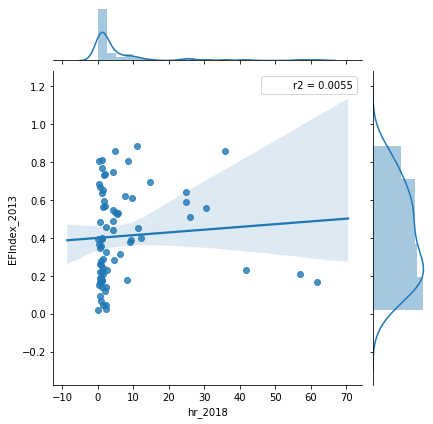

In [241]:
sns.jointplot(data=analysis_6, x='hr_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs HR 2013

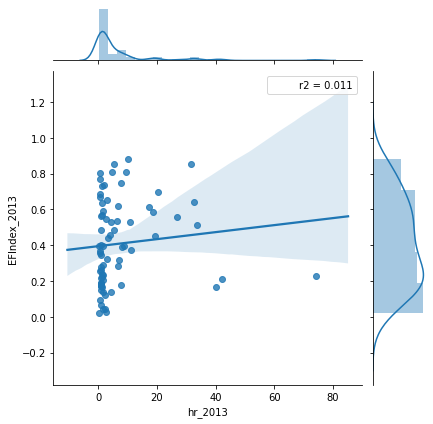

In [242]:
sns.jointplot(data=analysis_6, x='hr_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #7: EFI vs Inequality (ineq)

#### Iteration #1: EFI 2013 vs Inequality 2018

In [243]:
analysis_7=final_df[['EFIndex_2013', 'ineq_2018', 'ineq_2013']].dropna()
analysis_7.corr()

,EFIndex_2013,ineq_2018,ineq_2013
EFIndex_2013,1.000000,-0.549842,-0.555829
ineq_2018,-0.549842,1.000000,0.991425
ineq_2013,-0.555829,0.991425,1.000000


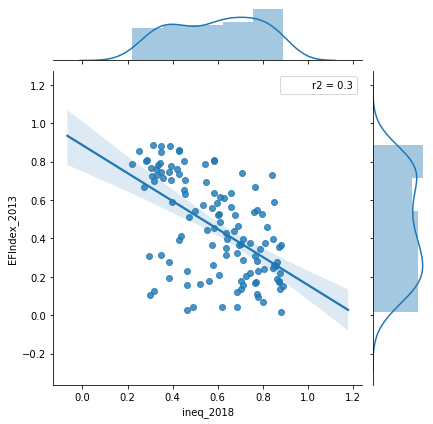

In [244]:
sns.jointplot(data=analysis_7, x='ineq_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs Inequality 2013

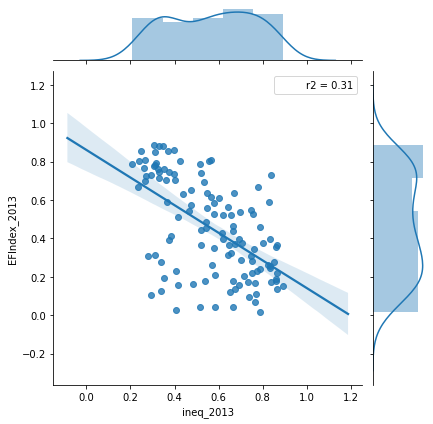

In [245]:
sns.jointplot(data=analysis_7, x='ineq_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #8: EFI vs Internet Users (IU)

#### Iteration #1: EFI 2013 vs IU 2018

In [246]:
analysis_8=final_df[['EFIndex_2013', 'iu_2018', 'iu_2013']].dropna()
analysis_8.corr()

,EFIndex_2013,iu_2018,iu_2013
EFIndex_2013,1.000000,-0.072199,-0.157943
iu_2018,-0.072199,1.000000,0.920779
iu_2013,-0.157943,0.920779,1.000000


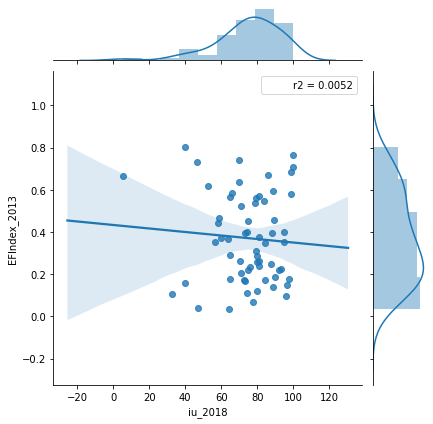

In [247]:
sns.jointplot(data=analysis_8, x='iu_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs IU 2013

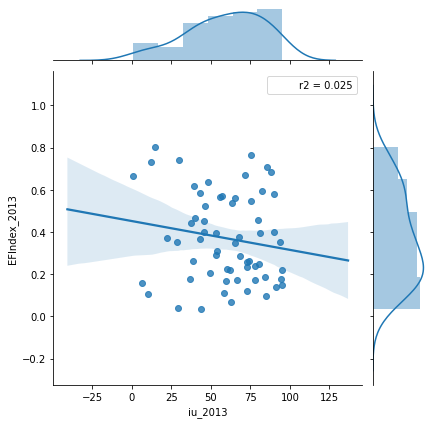

In [248]:
sns.jointplot(data=analysis_8, x='iu_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #9: EFI vs Life Expectancy (LE)

#### Iteration #1: EFI 2013 vs LE 2018

In [249]:
analysis_9=final_df[['EFIndex_2013', 'le_2018', 'le_2013']].dropna()
analysis_9.corr()

,EFIndex_2013,le_2018,le_2013
EFIndex_2013,1.000000,-0.516812,-0.512635
le_2018,-0.516812,1.000000,0.995010
le_2013,-0.512635,0.995010,1.000000


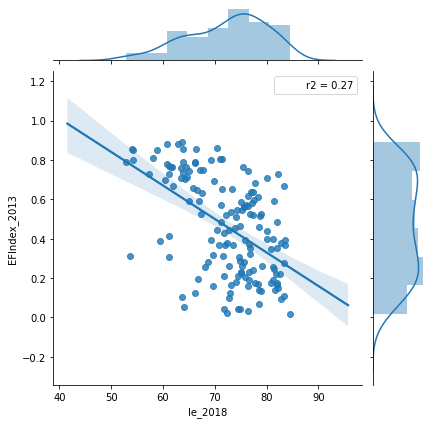

In [250]:
sns.jointplot(data=analysis_9, x='le_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

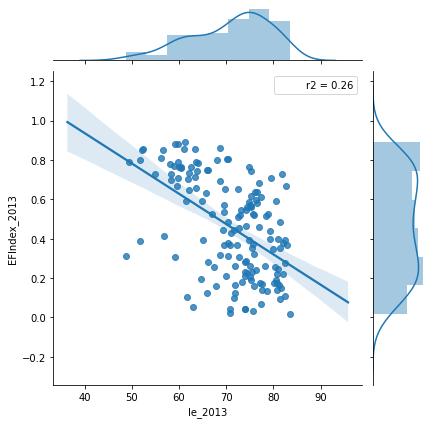

In [251]:
sns.jointplot(data=analysis_9, x='le_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #10: EFI vs Population (POP)

#### Iteration #1: EFI 2013 vs Population 2018

In [252]:
analysis_10=final_df[['Country','EFIndex_2013', 'pop_2018', 'pop_2013']].dropna()
analysis_10.corr()
len(analysis_10)

153

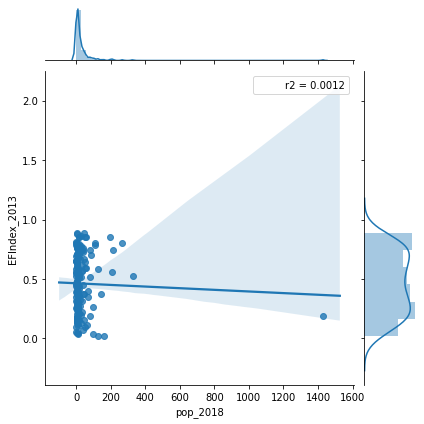

In [253]:
sns.jointplot(data=analysis_10, x='pop_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

Get rid of China outlier so data can be better interpreted

In [254]:
analysis_10.sort_values('pop_2018', ascending=False)
analysis_10.drop([35], inplace=True)

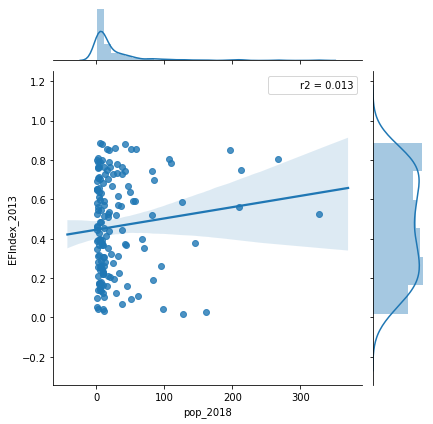

In [255]:
sns.jointplot(data=analysis_10, x='pop_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs Population 2013

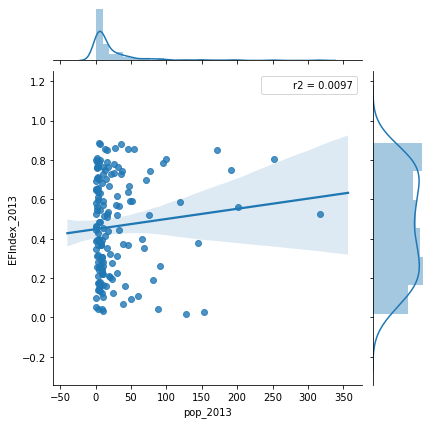

In [256]:
sns.jointplot(data=analysis_10, x='pop_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #11: EFI vs Skilled Labor (SL)

#### Iteration #1: EFI 2013 vs SL 2018

In [257]:
analysis_11=final_df[['Country','EFIndex_2013', 'sl_2018', 'sl_2013']].dropna()
analysis_11.corr()

,EFIndex_2013,sl_2018,sl_2013
EFIndex_2013,1.000000,-0.375020,-0.438985
sl_2018,-0.375020,1.000000,0.891934
sl_2013,-0.438985,0.891934,1.000000


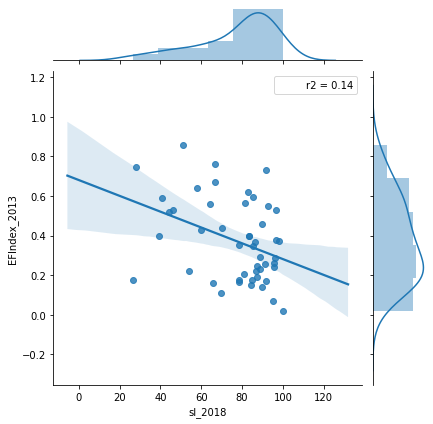

In [258]:
sns.jointplot(data=analysis_11, x='sl_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs SL 2013

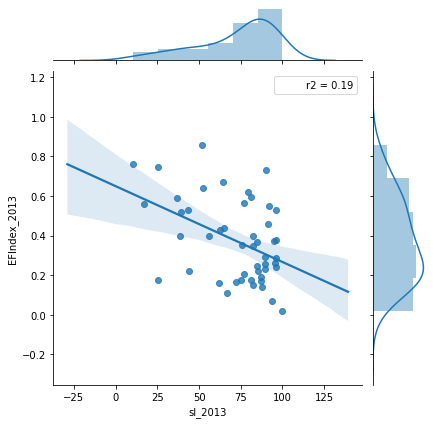

In [259]:
sns.jointplot(data=analysis_11, x='sl_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #12: EFI vs Employment (EMP)

#### Iteration #1: EFI 2013 vs EMP 2018

In [260]:
analysis_12=final_df[['EFIndex_2013', 'emp_2018', 'emp_2013']].dropna()
analysis_12.corr()

,EFIndex_2013,emp_2018,emp_2013
EFIndex_2013,1.000000,0.21956,0.249211
emp_2018,0.219560,1.00000,0.984080
emp_2013,0.249211,0.98408,1.000000


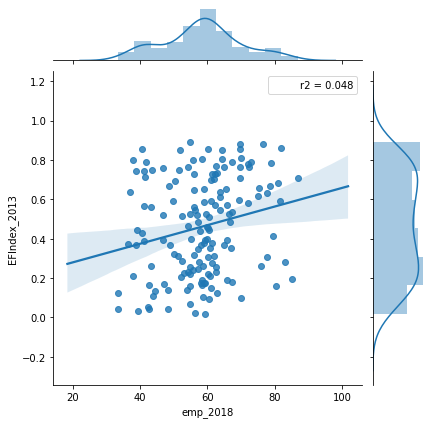

In [261]:
sns.jointplot(data=analysis_12, x='emp_2018', y='EFIndex_2013', kind='reg', stat_func=r2)

#### Iteration #2: EFI 2013 vs EMP 2013

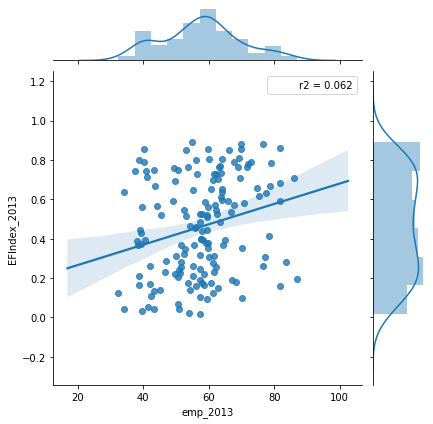

In [262]:
sns.jointplot(data=analysis_12, x='emp_2013', y='EFIndex_2013', kind='reg', stat_func=r2)

# Analysis #13: HDI vs WHR

In [263]:
analysis_13=final_df[['EFIndex_2013', 'Happiness score', 'hdi_2018']].dropna()
analysis_13.corr()

,EFIndex_2013,Happiness score,hdi_2018
EFIndex_2013,1.000000,-0.233367,-0.463047
Happiness score,-0.233367,1.000000,0.782495
hdi_2018,-0.463047,0.782495,1.000000


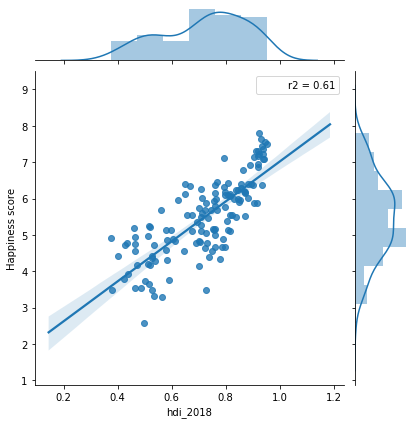

In [264]:
sns.jointplot(data=analysis_13, x='hdi_2018', y='Happiness score', kind='reg', stat_func=r2)

# Analysis #14: EFI vs WHR

In [265]:
analysis_14=final_df[['EFIndex_2013', 'Happiness score']].dropna()
analysis_14.corr()

,EFIndex_2013,Happiness score
EFIndex_2013,1.000000,-0.233367
Happiness score,-0.233367,1.000000


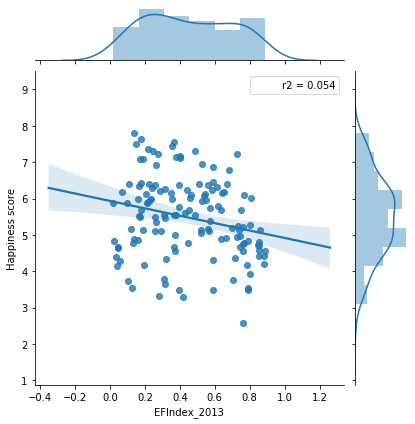

In [266]:
sns.jointplot(data=analysis_13, x='EFIndex_2013', y='Happiness score', kind='reg', stat_func=r2)

# Lasso regression

In [267]:
## We create a copy to protect the original dataframe.
df2=final_df.copy()

## We see there being alot of NaN values for certain variables.
df2.isna().sum()

HDI Rank (2018)      0
Country              0
hdi_2013             0
hdi_2018             0
EFIndex_2013        35
sy_2013              0
sy_2018              0
gd_2013             24
gd_2018             24
gni_2013             0
gni_2018             0
hr_2013            103
hr_2018            103
ineq_2013           56
ineq_2018           56
iu_2013            118
iu_2018            118
le_2013              0
le_2018              0
pop_2013             0
pop_2018             0
sl_2013            134
sl_2018            134
emp_2013            10
emp_2018            10
ei_2013             62
ei_2018             62
Happiness score     42
dtype: int64

In [268]:
## The plan is to fill these NaN values with a substitute value.
## The placeholder value will be a country's HDI score multiplied by its highest value in a given dimension.
## Here we collect the highest scores in each given dimension to facilitate that formula.
iu_max=df2.iu_2013.max()
hr_max=df2.hr_2013.max()
sl_max=df2.sl_2013.max()
emp_max=df2.emp_2013.max()
ei_max=df2.ei_2013.max()
gd_max=df2.gd_2013.max()
ineq_max=df2.ineq_2013.max()

In [269]:
## We have disabled the 2013 data because it is redundant at this point.
## Here we execute the specified placeholder data formula.

#df2.iu_2013.fillna(iu_max*df2.hdi_2013, inplace=True)
df2.iu_2018.fillna(iu_max*df2.hdi_2018, inplace=True)
#df2.hr_2013.fillna(hr_max*(1-df2.hdi_2013), inplace=True)
df2.hr_2018.fillna(hr_max*(1-df2.hdi_2018), inplace=True)
#df2.sl_2013.fillna(sl_max*df2.hdi_2013, inplace=True)
df2.sl_2018.fillna(sl_max*df2.hdi_2018, inplace=True)
#df2.emp_2013.fillna(emp_max*df2.hdi_2013, inplace=True)
df2.emp_2018.fillna(emp_max*df2.hdi_2018, inplace=True)
#df2.ei_2013.fillna(ei_max*df2.hdi_2013, inplace=True)
df2.ei_2018.fillna(ei_max*df2.hdi_2018, inplace=True)
#df2.gd_2013.fillna(gd_max*df2.hdi_2013, inplace=True)
df2.gd_2018.fillna(gd_max*df2.hdi_2018, inplace=True)
#df2.ineq_2013.fillna(ineq_max*(1-df2.hdi_2013), inplace=True)
df2.ineq_2018.fillna(ineq_max*(1-df2.hdi_2018), inplace=True)

In [270]:
## We drop all columns from 2013 as a result.
df2.drop(columns=['hdi_2013', 'sy_2013', 'gd_2013', 'gni_2013', 'hr_2013', 'ineq_2013', 'iu_2013', 'le_2013', 
                  'pop_2013', 'sl_2013', 'emp_2013', 'ei_2013'], inplace=True)

In [271]:
## We now see a massively reduced NaN count
## What NaN remains are expected from the nations that do not exist between HDI, WHR and EFI.
df2.isnull().sum()

HDI Rank (2018)     0
Country             0
hdi_2018            0
EFIndex_2013       35
sy_2018             0
gd_2018             0
gni_2018            0
hr_2018             0
ineq_2018           0
iu_2018             0
le_2018             0
pop_2018            0
sl_2018             0
emp_2018            0
ei_2018             0
Happiness score    42
dtype: int64

In [272]:
## We drop the NaN values now for lasso.
df_for_lasso=df2.dropna(axis=0)

## We now generate the X and Y for our analysis.
X=df_for_lasso.drop(['Country', 'Happiness score', 'HDI Rank (2018)', 'hdi_2018'], axis=1)
Y=df_for_lasso['Happiness score']
len(df_for_lasso)

136

In [273]:
## We now create the lasso model.
regLasso = linear_model.Lasso()

In [274]:
## We now fit the X and Y dimensions.
regLasso.fit(X,Y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [275]:
## The next 3 lines, lasso regression scores are generated.
d = {X.columns[i] : regLasso.coef_[i] for i in range(0,len(X.columns))}

In [276]:
s = pd.Series(d)

In [277]:
s[s!=0].sort_values()

ei_2018    -0.001250
pop_2018   -0.000138
gni_2018    0.000034
iu_2018     0.009943
le_2018     0.016331
dtype: float64

In [278]:
regLasso.score(X, Y)

0.6291423794145483

# Lasso prediction 

In [279]:
from sklearn.model_selection import train_test_split

In [280]:
## We generate the testing and training sets.
X_train, X_test, Y_train, Y_test = \
train_test_split(X,Y, test_size=0.1, random_state=0)

In [281]:
## We train the data.
regLasso.fit(X_train, Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [282]:
## We now make the prediction.
y_pred=regLasso.predict(X_test)

In [283]:
## The prediction variable.
y_pred

array([5.57614747, 6.58044996, 5.35388742, 5.53358396, 4.46708678,
       4.74654424, 4.23577775, 4.5350055 , 6.84979757, 5.98700272,
       6.02698994, 4.5825139 , 5.28968032, 4.5744851 ])

In [284]:
## Results of the prediction using MAD method.
(y_pred - Y_test).abs().mean()

0.48195737704711067

In [285]:
## Results of the prediction using MSE method.
((y_pred-Y_test)**2).mean()

0.3257764148791344

In [286]:
d2 = {X_train.columns[i] : regLasso.coef_[i] for i in range(0,len(X_train.columns))}

In [287]:
s2 = pd.Series(d2)

In [288]:
s2[s2!=0].sort_values()

ei_2018    -0.001087
pop_2018   -0.000181
gni_2018    0.000032
iu_2018     0.009372
le_2018     0.019303
dtype: float64

# Decision Tree for predicting happiness

In [289]:
import sklearn.tree

In [290]:
## We once again reuse the X and Y dimensions established back in the lasso sections.
dt = sklearn.tree.DecisionTreeRegressor(max_depth = 2)
dt.fit(X,Y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

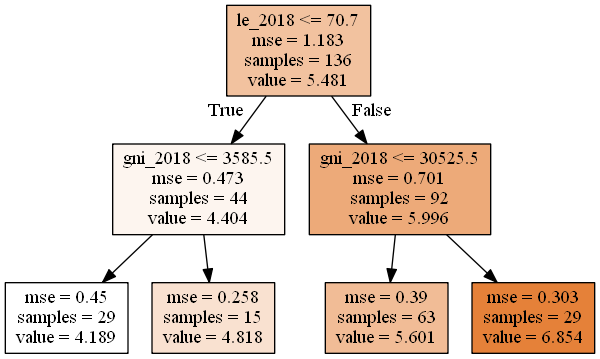

In [291]:
## The decision tree is generated.

import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())